## **Introduction**

Colonoscopy is the gold standard for detection and assessment of these polyps with subsequent biopsy and removal of the polyps.

Kvasir-SEG Dataset:
* Kvasir-SEG is an open-access dataset of gastrointestinal polyp images and corresponding segmentation masks, manually annotated and verified by an experienced gastroenterologist.
* The Kvasir-SEG dataset contains 1000 polyp images and thier ground truth. 
* The resolution of the images contained in Kvasir-SEG varies from 332x487 to 1920x1072 pixels. 
* The images and its corresponding masks are stored in two separate folders with the same filename. 
* The image files are encoded using JPEG compression.

The polyps detection at an early stage can play a crucial role in improving prevention of and survival from colorectal cancer.

# **1. Importing Labraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
import random
from keras_preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
import tensorflow.keras.backend as K
import math

# Measurment
import tensorflow as tf
import tensorflow.keras.metrics as metrics

# **2. Reading Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Training Set**

In [ ]:
os.chdir("/content/drive/MyDrive/Kvasir-SEG")

images_direction = './augmented_images'
masks_direction = './augmented_masks'

imageNames = os.listdir(images_direction)
maskNames = os.listdir(masks_direction)

In [ ]:
imageNames.sort()
maskNames.sort()

In [ ]:
len(maskNames)

4800

In [ ]:
images = []
images_names = []
masks = []
masks_names = []
img_height = 128
img_width = 128
channels = 1

In [ ]:
for imageName in tqdm(imageNames):
  temp = imageName.rsplit('.', 1)[0]
  maskName = temp + '_mask.jpg'
  if maskName in maskNames:
    img = load_img(os.path.join(images_direction, imageName), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    img_array = img_to_array(img, data_format='channels_last', dtype=np.float32)
    images.append(img_array)
    images_names.append(imageName)
    mask = load_img(os.path.join(masks_direction, maskName), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    mask_array = img_to_array(mask, data_format='channels_last', dtype=np.float32)
    masks.append(mask_array)
    masks_names.append(maskName)

  0%|          | 0/4810 [00:00<?, ?it/s]

In [ ]:
# Reshaping the data
images = np.array(images).reshape(-1, img_height, img_width, channels)
masks = np.array(masks).reshape(-1, img_height, img_width, channels)
images_names = np.array(images_names)
masks_names = np.array(masks_names)

print(' Number of training images: {}\n images_shape: {}\n Number of masks: {}\n masks_shape: {}'.format(len(images_names), images.shape, len(masks_names), masks.shape))


 Number of training images: 4800
 images_shape: (4800, 128, 128, 1)
 Number of masks: 4800
 masks_shape: (4800, 128, 128, 1)


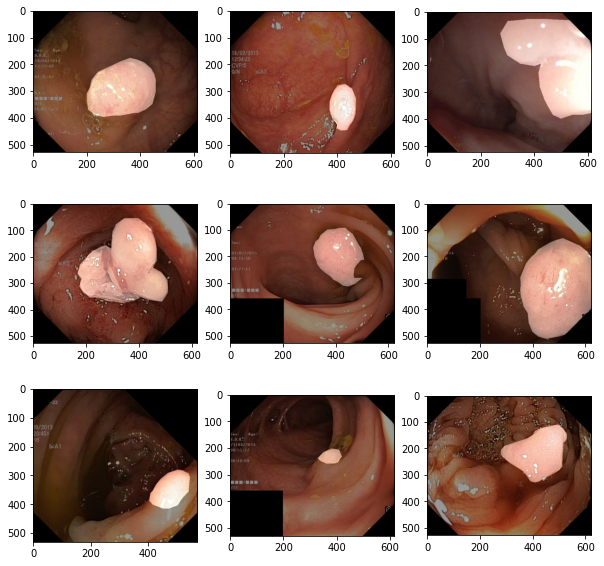

In [ ]:
datapath = "/content/drive/MyDrive/Kvasir-SEG/training/"

masks2 = [os.path.join(datapath,i) for i in os.listdir(datapath) if "mask" in i]
imgs2 = [i.replace("_mask","") for i in masks2]

df = pd.DataFrame({"image":imgs2,"mask":masks2})

rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df))
    fig.add_subplot(rows,cols,i)
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
plt.show()

### **Validating Set**

In [ ]:
os.chdir("/content/drive/MyDrive/Kvasir-SEG")

images_direction_val = './val_image'
masks_direction_val = './val_masks'

imageNames_val = os.listdir(images_direction_val)
maskNames_val = os.listdir(masks_direction_val)

In [ ]:
imageNames_val.sort()
maskNames_val.sort()

In [ ]:
images_val = []
images_names_val = []
masks_val = []
masks_names_val = []

In [ ]:
for imageName_val in tqdm(imageNames_val):
  temp = imageName_val.rsplit('.', 1)[0]
  maskName_val = temp + '_mask.jpg'
  if maskName_val in maskNames_val:
    img_val = load_img(os.path.join(images_direction_val, imageName_val), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    img_array = img_to_array(img_val, data_format='channels_last', dtype=np.float32)
    images_val.append(img_array)
    images_names_val.append(imageName_val)
    mask_val = load_img(os.path.join(masks_direction_val, maskName_val), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    mask_array = img_to_array(mask_val, data_format='channels_last', dtype=np.float32)
    masks_val.append(mask_array)
    masks_names_val.append(maskName_val)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Reshaping the data
images_val = np.array(images_val).reshape(-1, img_height, img_width, channels)
masks_val = np.array(masks_val).reshape(-1, img_height, img_width, channels)
images_names_val = np.array(images_names_val)
masks_names_val = np.array(masks_names_val)

print('Number of validting images: {} | images_shape: {} | Number of masks: {} | masks_shape: {}'.format(len(images_names_val), images_val.shape, len(masks_names_val), masks_val.shape))

Number of validting images: 100 | images_shape: (100, 128, 128, 1) | Number of masks: 100 | masks_shape: (100, 128, 128, 1)


### **Testing Set**

In [ ]:
os.chdir("/content/drive/MyDrive/Kvasir-SEG")

images_direction_test = './test_image'
masks_direction_test = './test_mask'

imageNames_test = os.listdir(images_direction_test)
maskNames_test = os.listdir(masks_direction_test)

In [ ]:
imageNames_test.sort()
maskNames_test.sort()

In [ ]:
images_test = []
images_names_test = []
masks_test = []
masks_names_test = []

In [ ]:
for imageName_test in tqdm(imageNames_test):
  temp = imageName_test.rsplit('.', 1)[0]
  maskName_test = temp + '_mask.jpg'
  if maskName_test in maskNames_test:
    img = load_img(os.path.join(images_direction_test, imageName_test), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    img_array = img_to_array(img, data_format='channels_last', dtype=np.float32)
    images_test.append(img_array)
    images_names_test.append(imageName_test)
    mask = load_img(os.path.join(masks_direction_test, maskName_test), color_mode='grayscale', target_size=(img_height, img_width), interpolation='nearest')
    mask_array = img_to_array(mask, data_format='channels_last', dtype=np.float32)
    masks_test.append(mask_array)
    masks_names_test.append(maskName_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Reshaping the data
images_test = np.array(images_test).reshape(-1, img_height, img_width, channels)
masks_test = np.array(masks_test).reshape(-1, img_height, img_width, channels)
images_names_test = np.array(images_names_test)
masks_names_test = np.array(masks_names_test)

print('Number of testing images: {} | images_shape: {} | Number of masks: {} | masks_shape: {}'.format(len(images_names_test), images_test.shape, len(masks_names_test), masks_test.shape))

Number of testing images: 100 | images_shape: (100, 128, 128, 1) | Number of masks: 100 | masks_shape: (100, 128, 128, 1)


# **3. Data Preprocessing**

**Normalizing**

In [ ]:
images /= 255.
masks /= 255.

In [ ]:
print('Training Images: Max-Val: {}, Min-Val: {}'.format(np.amax(images), np.amin(images)))
print('Training Masks: Max-Val: {}, Min-Val: {}'.format(np.amax(masks), np.amin(masks)))

Training Images: Max-Val: 1.0, Min-Val: 0.0
Training Masks: Max-Val: 1.0, Min-Val: 0.0


In [ ]:
images_val /= 255.
masks_val /= 255.

In [ ]:
print('Validation Images: Max-Val: {}, Min-Val: {}'.format(np.amax(images_val), np.amin(images_val)))
print('Validation Masks: Max-Val: {}, Min-Val: {}'.format(np.amax(masks_val), np.amin(masks_val)))

Validation Images: Max-Val: 1.0, Min-Val: 0.0
Validation Masks: Max-Val: 1.0, Min-Val: 0.0


In [ ]:
images_test /= 255.
masks_test /= 255.

In [ ]:
print('Testing Images: Max-Val: {}, Min-Val: {}'.format(np.amax(images_test), np.amin(images_test)))
print('Testing Masks: Max-Val: {}, Min-Val: {}'.format(np.amax(masks_test), np.amin(masks_test)))

Testing Images: Max-Val: 1.0, Min-Val: 0.0
Testing Masks: Max-Val: 1.0, Min-Val: 0.0


# **4. Buliding U-Net Model**

In [ ]:
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', dice_coef])

    model.summary()
    
    return model

unet_model = simple_unet_model(img_height, img_width, channels)
unet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 8)  80          ['input_2[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 8)  0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 8)  584         ['dropout_9[0][0]']        

# **5. Training U-Net Model**

In [ ]:
training_process = unet_model.fit(images, masks, batch_size=8, epochs=100, verbose=1, shuffle=True, validation_data = (images_val, masks_val))
unet_model.save('./unet_model_128.h5')

Epoch 1/100
600/600 [==============================] - 435s 718ms/step - loss: 0.4734 - accuracy: 0.7373 - dice_coef: 0.2487 - val_loss: 0.4060 - val_accuracy: 0.8482 - val_dice_coef: 0.2657
Epoch 2/100
600/600 [==============================] - 427s 712ms/step - loss: 0.3442 - accuracy: 0.8490 - dice_coef: 0.2988 - val_loss: 0.3527 - val_accuracy: 0.8452 - val_dice_coef: 0.2625
Epoch 3/100
600/600 [==============================] - 426s 710ms/step - loss: 0.3271 - accuracy: 0.8568 - dice_coef: 0.3323 - val_loss: 0.3437 - val_accuracy: 0.8505 - val_dice_coef: 0.2901
Epoch 4/100
600/600 [==============================] - 423s 705ms/step - loss: 0.3152 - accuracy: 0.8616 - dice_coef: 0.3523 - val_loss: 0.3288 - val_accuracy: 0.8482 - val_dice_coef: 0.2754
Epoch 5/100
600/600 [==============================] - 424s 707ms/step - loss: 0.3072 - accuracy: 0.8641 - dice_coef: 0.3672 - val_loss: 0.3971 - val_accuracy: 0.8464 - val_dice_coef: 0.1853
Epoch 6/100
600/600 [========================

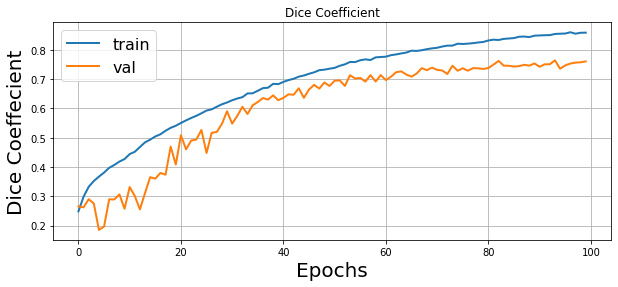

In [ ]:
history = training_process
plt.figure(figsize=(10,4))
plt.plot(history.history['dice_coef'], lw = 2)
plt.plot(history.history['val_dice_coef'], lw = 2)
plt.title('Dice Coefficient')
plt.ylabel('Dice Coeffecient', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.legend(['train', 'val'], loc='best', fontsize=16)
plt.grid()
plt.show()

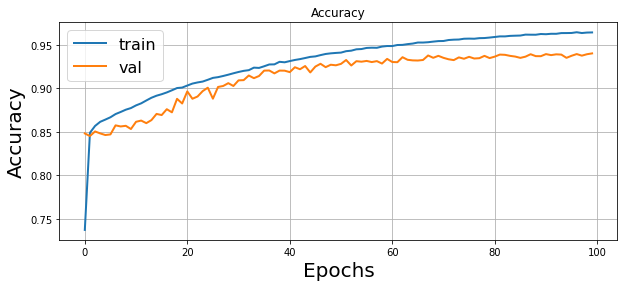

In [ ]:
history = training_process
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], lw = 2)
plt.plot(history.history['val_accuracy'], lw = 2)
plt.title('Accuracy')
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.legend(['train', 'val'], loc='best', fontsize=16)
plt.grid()
plt.show()

# **6. Evaluation Model**

In [ ]:
unet_model.evaluate(images_test, masks_test, verbose=1)

4/4 [==============================] - 2s 405ms/step - loss: 0.3302 - accuracy: 0.9065 - dice_coef: 0.7231


[0.3301808536052704, 0.9065356254577637, 0.7230799198150635]